In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop_generator_protein_layer_norm import *
from seqprop.predictor import *
from seqprop.optimizer import *

from seqprop_protein_utils import *
from seqprop_rosetta_kl_helper import _get_kl_divergence_numpy, _get_smooth_kl_divergence_numpy, _get_smooth_circular_kl_divergence_numpy
from seqprop_rosetta_kl_helper import _get_kl_divergence_keras, _get_smooth_kl_divergence_keras, _get_smooth_circular_kl_divergence_keras
from basinhopping_rosetta import *

from definitions.trrosetta_single_model_no_msa_batched_simpler_1d_features_2 import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

from adam_accumulate_keras import *

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [5]:

#Define target isoform loss function
def get_kl_loss(target_p_dist, target_p_theta, target_p_phi, target_p_omega) :
    
    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs
        
        kl_dist, kl_theta, kl_phi, kl_omega = _get_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta, kl_phi, kl_omega = _get_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func_smooth_kl(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta, kl_phi, kl_omega = _get_smooth_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func_smooth_circular_kl(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta_sin, kl_theta_cos, kl_phi, kl_omega_sin, kl_omega_cos = _get_smooth_circular_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta_sin + kl_theta_cos + kl_phi + kl_omega_sin + kl_omega_cos, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func, val_loss_func_smooth_kl, val_loss_func_smooth_circular_kl


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)


class DummyValidationCallback(Callback):
    def __init__(self, val_name) :
        self.val_name = val_name
        
        self.val_loss_history = []

class DummyFlexibleSeqPropMonitor(Callback):
    def __init__(self, measure_name='Measure') :
        self.measure_name = measure_name
        self.measure_history = [] = []
        self.entropy_history = []
        self.nt_swap_history = []
        self.prev_optimized_pwm = None

        self.n_epochs = 0

def _tmp_load_model(model_path) :

    saved_model = load_model(model_path, custom_objects = {
        'InstanceNormalization' : InstanceNormalization,
        'reweight' : reweight,
        'wmin' : 0.8,
        'msa2pssm' : msa2pssm,
        'tf' : tf,
        'fast_dca' : fast_dca,
        'keras_collect_features' : keras_collect_features
    })
    
    return saved_model


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(loss_funcs, val_loss_funcs, val_loss_funcs_smooth_kl, val_loss_funcs_smooth_circular_kl, transform_funcs, temperature_params, t_distos, msa_one_hots, seq_length=100, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100, logit_init_mode='glorot_uniform', optimizer=None) :
    
    if eval_mode == 'basinhopping' :
        residues = list("ARNDCQEGHILKMFPSTWYV")
        residue_map = {
            residue : residue_ix
            for residue_ix, residue in enumerate(residues)
        }
        acgt_encoder = IdentityEncoder(seq_length, residue_map)
        
        predictor = _tmp_load_model(model_path)
        predictor.compile(
            loss='mse',
            optimizer=keras.optimizers.SGD(lr=0.1)
        )
        
        n_iters_per_temperate, n_swaps, t_init, t_func = temperature_params[0]
        
        evolved_sequences, evolved_scores, evolved_scores_smooth_kl, evolved_scores_smooth_circular_kl = run_simulated_annealing_batch(predictor, t_distos, msa_one_hots[0], "$" * seq_length, acgt_encoder, n_sequences=n_sequences, n_iters=steps_per_epoch, n_iters_per_temperate=n_iters_per_temperate, temperature_init=t_init, temperature_func=t_func, n_swaps=n_swaps, verbose=False)
        evolved_losses = -evolved_scores
        evolved_losses_smooth_kl = -evolved_scores_smooth_kl
        evolved_losses_smooth_circular_kl = -evolved_scores_smooth_circular_kl
        
        train_history = DummyValidationCallback('loss')
        train_history.val_loss_history = np.mean(evolved_losses * n_sequences, axis=0).tolist()
        
        valid_history = DummyValidationCallback('val_loss')
        valid_history.val_loss_history = np.mean(evolved_losses, axis=0).tolist()
        
        valid_history_smooth_kl = DummyValidationCallback('val_loss_smooth_kl')
        valid_history_smooth_kl.val_loss_history = np.mean(evolved_losses_smooth_kl, axis=0).tolist()
        
        valid_history_smooth_circular_kl = DummyValidationCallback('val_loss_smooth_circular_kl')
        valid_history_smooth_circular_kl.val_loss_history = np.mean(evolved_losses_smooth_circular_kl, axis=0).tolist()
        
        opt_pwm = np.expand_dims(np.expand_dims(acgt_encoder.encode(evolved_sequences[0]), axis=-1), axis=0)
        
        return [opt_pwm], [train_history], [valid_history], [valid_history_smooth_kl], [valid_history_smooth_circular_kl]
    
    n_objectives = len(loss_funcs)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    valid_histories_smooth_kl = []
    valid_histories_smooth_circular_kl = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        val_loss_func_smooth_kl = val_loss_funcs_smooth_kl[obj_ix]
        val_loss_func_smooth_circular_kl = val_loss_funcs_smooth_circular_kl[obj_ix]
        transform_func = transform_funcs[obj_ix]
        msa_one_hot = msa_one_hots[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample', logit_init_mode=logit_init_mode)
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_valid_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='max', master_generator=seqprop_generator, logit_init_mode=logit_init_mode)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        _, valid_loss_model_smooth_kl = build_loss_model(valid_predictor, val_loss_func_smooth_kl)
        _, valid_loss_model_smooth_circular_kl = build_loss_model(valid_predictor, val_loss_func_smooth_circular_kl)
        
        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=optimizer)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        #measure_func = lambda pred_outs: np.mean(np.expand_dims(pred_outs[1], axis=0) if len(pred_outs[1].shape) <= 2 else pred_outs[1], axis=0)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        #valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=600, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        valid_history_smooth_kl = ValidationCallback('val_loss_smooth_kl', valid_loss_model_smooth_kl, 1)
        valid_history_smooth_circular_kl = ValidationCallback('val_loss_smooth_circular_kl', valid_loss_model_smooth_circular_kl, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            #valid_monitor,
            train_history,
            valid_history,
            valid_history_smooth_kl,
            valid_history_smooth_circular_kl
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        valid_history_smooth_kl.val_loss_model = None
        valid_history_smooth_circular_kl.val_loss_model = None
        
        _, opt_pwm, _, _, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        seqprop_predictors.append(opt_pwm)
        #valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)
        valid_histories_smooth_kl.append(valid_history_smooth_kl)
        valid_histories_smooth_circular_kl.append(valid_history_smooth_circular_kl)

    return seqprop_predictors, train_histories, valid_histories, valid_histories_smooth_kl, valid_histories_smooth_circular_kl


In [6]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), 'trRosetta/network/model2019_07')
model_name = 'model.xaa_batched_no_drop_2.h5'
model_path = os.path.join(save_dir, model_name)


In [7]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


(1, 1, 72, 21)
(1, 72, 72, 37)


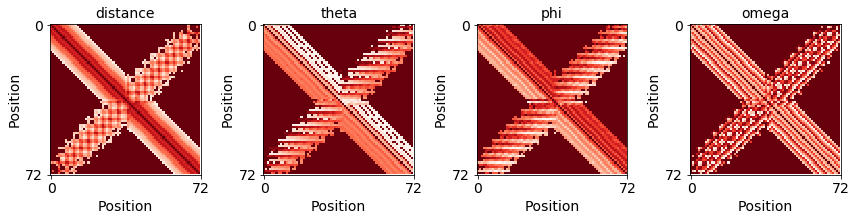

In [9]:
msa_file = "trRosetta/example/TR005257.a3m"

fig_name = "TR005257"
save_figs = False

a3m = parse_a3m(msa_file)

msa_one_hot = np.expand_dims(one_hot_encode_msa(a3m), axis=0)[:, :1, ...]

print(msa_one_hot.shape)

npz_file = "trRosetta/example/TR005257_xaa_corrected.npz"

npz_data = np.load(npz_file)

t_pd, t_pt, t_pp, t_po = npz_data['dist'], npz_data['theta'], npz_data['phi'], npz_data['omega']

print(t_pd.shape)


f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [t_pd, 'distance', ax_list[0]],
    [t_pt, 'theta', ax_list[1]],
    [t_pp, 'phi', ax_list[2]],
    [t_po, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_t_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_t_distribs.svg')
    plt.savefig(fig_name + '_t_distribs.eps')

plt.show()



In [ ]:

seeds = [1177, 14755, 74662, 112110, 252654]

#Run SeqProp Optimization

print("Running optimization experiment 'trRosetta Target Structure'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Sequence length
seq_length = msa_one_hot.shape[2]
#Number of steps (grad updates) per epoch
steps_per_epoch = 200 * 2
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

experiment_name_list = [
    'Sampled-IN 10x (Adam 0.01 0.5/0.9)'
]

eval_mode_list = [
    'sample'
]

normalize_logits_list = [
    True
]

n_samples_list = [
    5
]

temperature_params_list = [
    [None, None, None, None]
]

logit_init_modes = [
    'glorot_uniform'
]

optimizers = [
    lambda x: AdamAccumulate(lr=0.01, beta_1=0.5, beta_2=0.9, accum_iters=2)
]

result_dict = {
    'Sampled-IN 10x (Adam 0.01 0.5/0.9)' : {}
}

for experiment_name, eval_mode, normalize_logits, n_samples, temperature_params, logit_init_mode, optimizer_func in zip(experiment_name_list, eval_mode_list, normalize_logits_list, n_samples_list, temperature_params_list, logit_init_modes, optimizers) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    for rand_seed_ix, rand_seed in enumerate(seeds) :
    
        print("Running seed " + str(rand_seed_ix) + "...")

        K.clear_session()
        
        optimizer = optimizer_func(None)

        set_seed(rand_seed)

        losses, val_losses, val_losses_smooth_kl, val_losses_smooth_circular_kl = zip(*[
            get_kl_loss(
                t_pd,
                t_pt,
                t_pp,
                t_po
            )
        ])

        transforms = [
            None
        ]

        opt_pwms, train_histories, valid_histories, valid_histories_smooth_kl, valid_histories_smooth_circular_kl = run_seqprop(losses, val_losses, val_losses_smooth_kl, val_losses_smooth_circular_kl, transforms, [temperature_params], [t_pd, t_pt, t_pp, t_po], [msa_one_hot], seq_length, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch, logit_init_mode, optimizer)

        opt_pwm, train_history, valid_history, valid_history_smooth_kl, valid_history_smooth_circular_kl = opt_pwms[0], train_histories[0], valid_histories[0], valid_histories_smooth_kl[0], valid_histories_smooth_circular_kl[0]

        if rand_seed_ix > 0 :
            result_dict[experiment_name]['train_history'].val_loss_history.append(train_history.val_loss_history)
            result_dict[experiment_name]['valid_history'].val_loss_history.append(valid_history.val_loss_history)
            result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history.append(valid_history_smooth_kl.val_loss_history)
            result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history.append(valid_history_smooth_circular_kl.val_loss_history)
            
        else :
            train_history.val_loss_history = [train_history.val_loss_history]
            valid_history.val_loss_history = [valid_history.val_loss_history]
            valid_history_smooth_kl.val_loss_history = [valid_history_smooth_kl.val_loss_history]
            valid_history_smooth_circular_kl.val_loss_history = [valid_history_smooth_circular_kl.val_loss_history]
            
            result_dict[experiment_name] = {
                'opt_pwm' : opt_pwm,
                'train_history' : train_history,
                'valid_history' : valid_history,
                'valid_history_smooth_kl' : valid_history_smooth_kl,
                'valid_history_smooth_circular_kl' : valid_history_smooth_circular_kl
            }
    
    result_dict[experiment_name]['train_history'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['train_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history), axis=0).tolist()
    
    result_dict[experiment_name]['train_history'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['train_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history), axis=0).tolist()


In [11]:

for experiment_name in result_dict :
    for loss_str in result_dict[experiment_name] :
        if 'model' in dir(result_dict[experiment_name][loss_str]) :
            result_dict[experiment_name][loss_str].model = None


In [12]:
import pickle

pickle.dump({'result_dict' : result_dict}, open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_2.pickle", "wb"))


In [13]:

result_dict_part_2 = pickle.load(open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_2.pickle", "rb"))['result_dict']


In [14]:

for experiment_name in result_dict :
    for loss_str in result_dict[experiment_name] :
        if 'model' in dir(result_dict[experiment_name][loss_str]) :
            result_dict_part_2[experiment_name][loss_str].val_loss_history_median = [result_dict_part_2[experiment_name][loss_str].val_loss_history_median[i+1] for i in range(-1, n_epochs * steps_per_epoch) if (i+1) % 2 == 0]
            result_dict_part_2[experiment_name][loss_str].val_loss_history_mean = [result_dict_part_2[experiment_name][loss_str].val_loss_history_mean[i+1] for i in range(-1, n_epochs * steps_per_epoch) if (i+1) % 2 == 0]


In [15]:

pickle.dump({'result_dict' : result_dict_part_2}, open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_2_collapsed_steps.pickle", "wb"))
